# ANURAG SREEKUMAR (B00805019)
# VARUN GOPALAKRISHNAN (B00823111)

# Introduction

  The dataset consist of more 12000 resturants in Bengaluru which servers a wide variety of dishes from all over the world. The basic idea in analyzing this dataset is to get an idea about the factors that are affecting the rating of the resturants, type of resturants in that neighbourhood and the type of cuisines famous in that neighbourhood. To analyze this we are provided with a dataset that consist of the following attributes:
  

*   **url** contains the url of the restaurant in the zomato website
*   **address** contains the address of the restaurant in Bengaluru
*   **name** contains the name of the restaurant
*   **online_order** whether online ordering is available in the restaurant or not
*   **book_table** table book option available or not
*   **rate** contains the overall rating of the restaurant out of 5
*   **votes** contains total number of rating for the restaurant as of the above mentioned date
*   **phone** contains the phone number of the restaurant
*   **rest_type** restaurant type
*   **location** contains the neighborhood in which the restaurant is located
*   **dish_liked** dishes people liked in the restaurant
*   **cuisines** food styles, separated by comma
*  **approx_cost(for two people)** contains the approximate cost for meal for two people
*   **reviews_listlist** of tuples containing reviews for the restaurant, each tuple consists of two values, rating and review by the customer
*   **menu_item** contains list of menus available in the restaurant
*  **listed_in(city)** contains the neighborhood in which the restaurant is listed
*  **listed_in(type)** type of meal

# All imports necessary for execution

In [0]:
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.ticker as mtick


# Loading the CSV file

In [4]:
# Loading the CSV file which has all the data
# Place the CSV file in the google drive and it make it easier to fetch it from the Drive
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
data = pd.read_csv('/content/gdrive/My Drive/zomato.csv')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Plotting the graphs for trend analysis
  
   While plotting the data we are able to find that there are many attributes that do not contribute to the data analysis. The attributes such as URL, Address, Phone number,review_list, menu_item seems to be useless. Hence, we will be dropping these columns during the data cleaning phase.  
    
   **TREND ANALYSIS**
   
  

*    **Whitefield** has the most number of resturants
*  Most of the resturants in Banglore are of Quick bite resturant type
*  Most of the resturants provide Home Delivery services
*  There are many New resturants in Benglauru, most have the resturants have a rating of more than 3.8 out of 5
*  Cafe Coffee Day has the most number of outlets in Bengaluru.





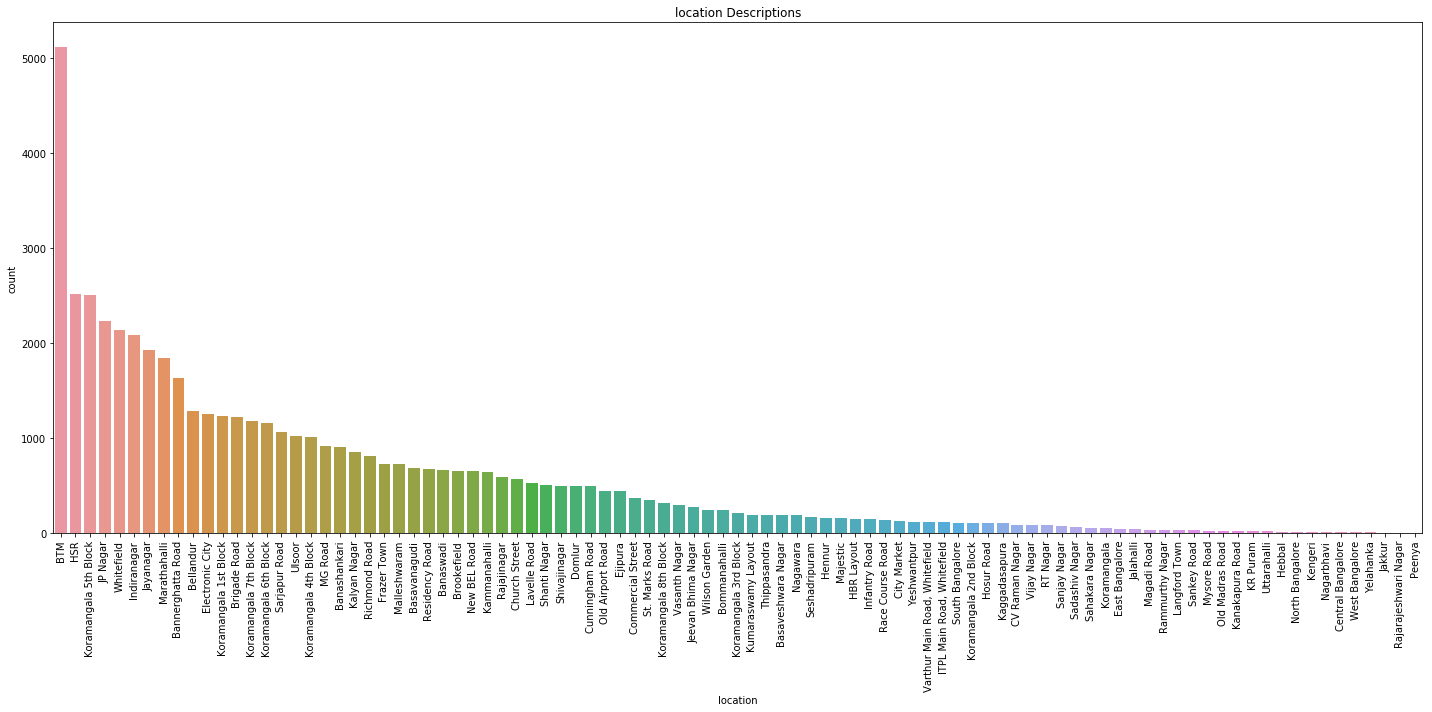

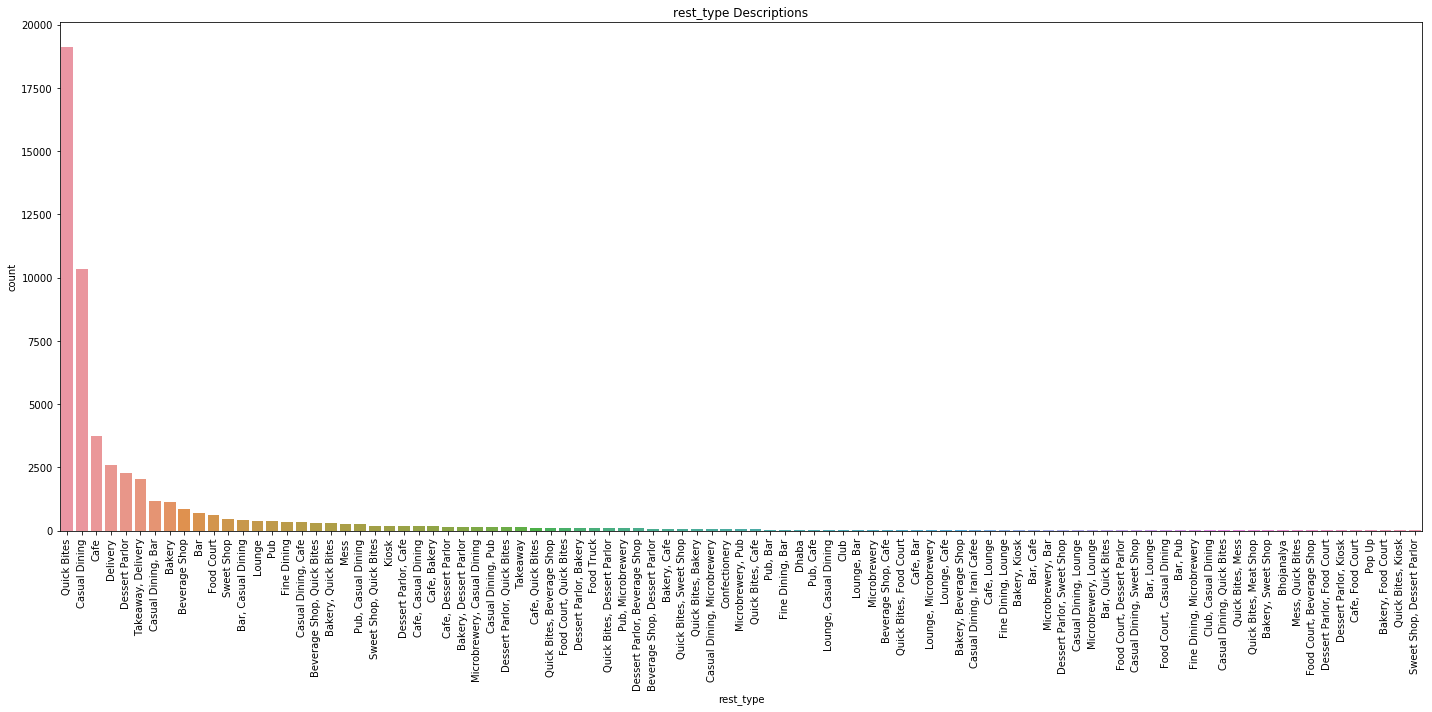

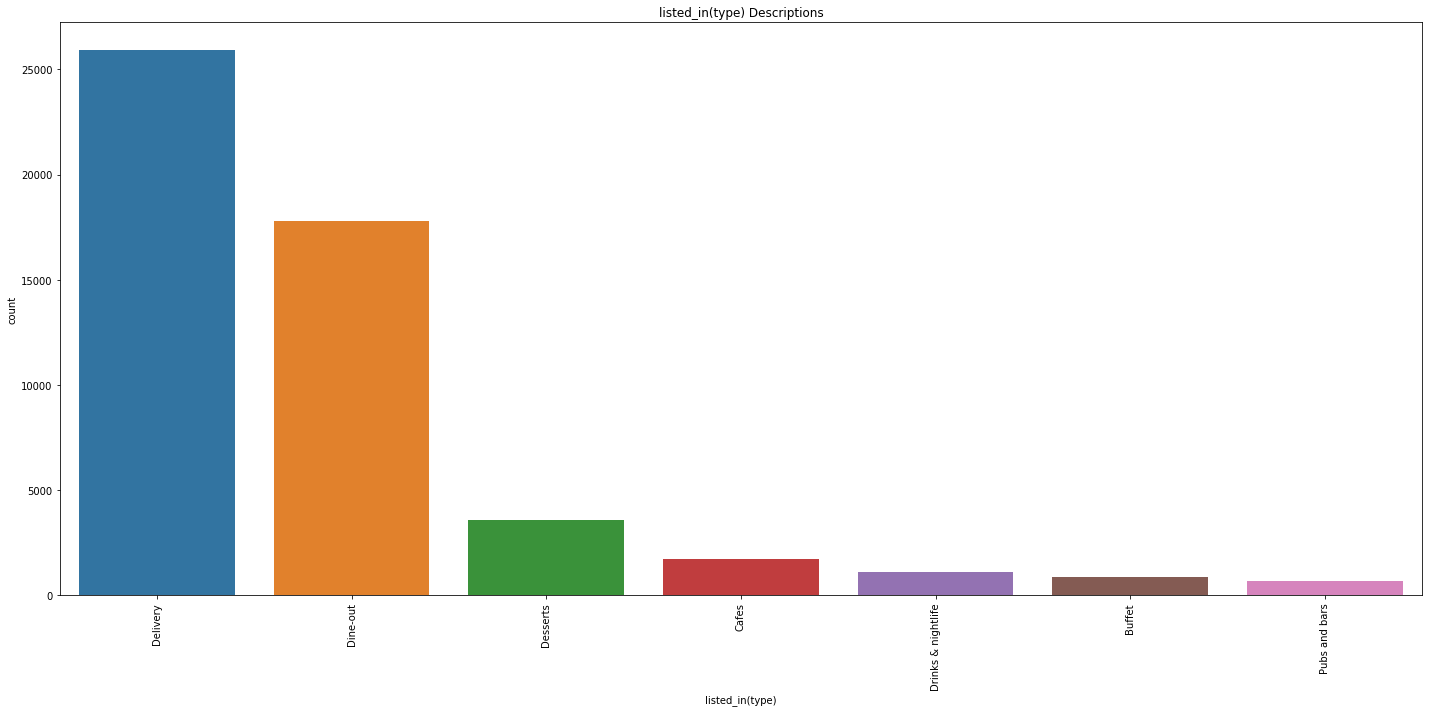

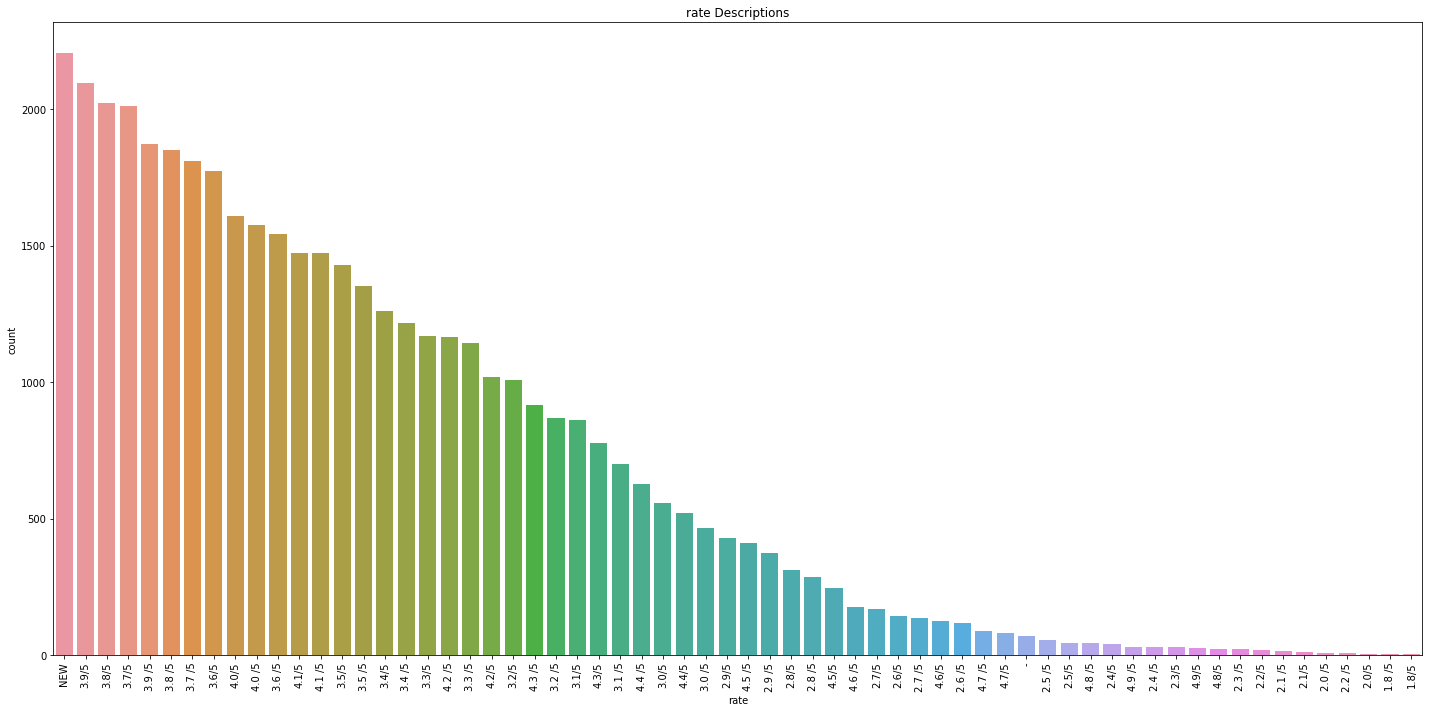

Text(0.5, 0, 'Number of outlets')

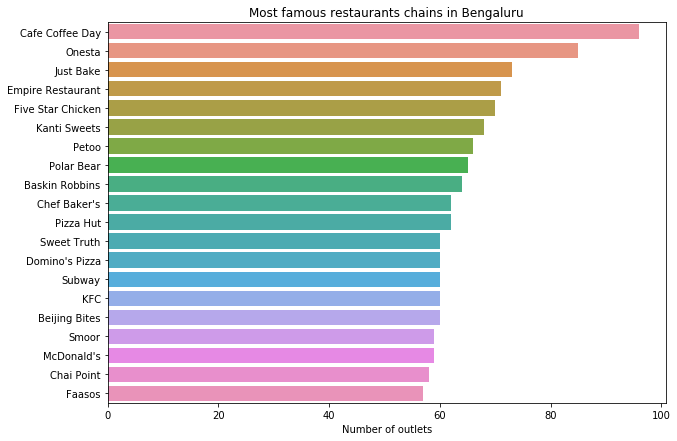

In [5]:
# bar graph to find trends in the dataset
def display_barChart(field):
    plt.figure(figsize=(20, 10))
    _temp = pd.DataFrame(data.groupby(field)[field].count())
    _temp.columns = ["count"]
    _temp = _temp.reset_index()
    _temp.columns = [field, "count"]
    _temp = _temp.sort_values(by="count", ascending=False)
    plt.title(field+" Descriptions")
    g = sns.barplot(data=_temp, x=field, y="count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


display_barChart("location")
display_barChart("rest_type")
display_barChart('listed_in(type)')
display_barChart('rate')

plt.figure(figsize=(10,7))
chains=data['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index)
plt.title("Most famous restaurants chains in Bengaluru")
plt.xlabel("Number of outlets")

# Data Cleaning

 We had a number of duplicate resturants in the dataset provided. We dropped the data with duplicate entires based on name and address attributes.  

1.   We dropped the columns that are not relevant to the analysis
2.   Replaced with binary value
3.   Rename columns as per convenience 
4.   Replace new resturants rating with np.nan
5.   Remove /5 from rating
6.   Remove ',' from average_cost
7.   Replacing rating of np.nan with median value

In [0]:
# sorting by resturant name
data.sort_values(by = ["name"], inplace=True)

Dropping duplicate resturants

In [0]:
# dropping duplicate resturants with same address
data.drop_duplicates(subset=["name","address"],keep='first', inplace=True)

In [0]:
# drop columns that does not contribute in model building
# listed_in(city) and location has same value, more than 50% of values in dish_liked, menu_item column is missing
data.drop(columns=['url', 'address', 'phone','reviews_list', 'dish_liked', 'menu_item', 'listed_in(city)'], inplace=True)

In [0]:
# replace with binary value
data['online_order'] = [0 if x == 'No' else 1 for x in data['online_order']]
data['book_table'] = [0 if x == 'No' else 1 for x in data['book_table']]

Renaming the columns

In [0]:
# rename columns as per convenience
data.rename(columns={'approx_cost(for two people)': 'average_cost','listed_in(type)': 'service_type','rate': 'rating'}, inplace=True)

In [0]:
# replace new resturants rating with np.nan
data.rating = data.rating.replace("NEW", np.nan)
data.rating = data.rating.replace("-", np.nan)
data.rating = data.rating.replace(" ", np.nan)
# print(df.shape)

Removing /5 from rating

In [0]:
# remove /5 from rating
data.rating = data.rating.astype(str)
data.rating = data.rating.apply(lambda x: x.replace('/5', ''))
data.rating = data.rating.apply(lambda x: float(x))

Removing ',' from average_cost

In [0]:
# remove ',' from average_cost
data.average_cost = data.average_cost.astype(str)
data.average_cost = data.average_cost.apply(lambda x: x.replace(',', ''))
data.average_cost = data.average_cost.apply(lambda x: float(x))
# print(df.head())

Replacing the NAN with median values

In [0]:
# replacing rating of np.nan with median value
data['rating'] = data['rating'].fillna(data['rating'].median())
data['average_cost'] = data['average_cost'].fillna(data['average_cost'].median())

# Bar graphs to show the trends in the data after data cleaning 

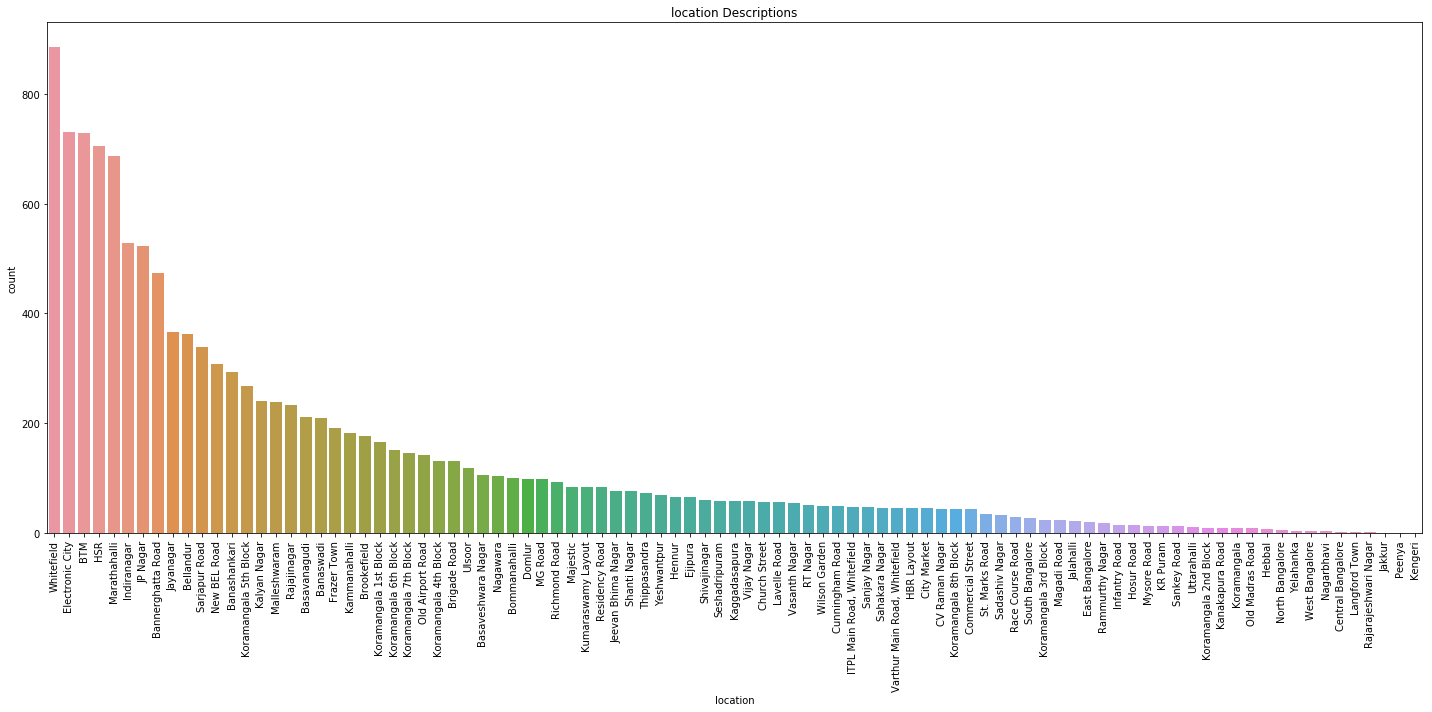

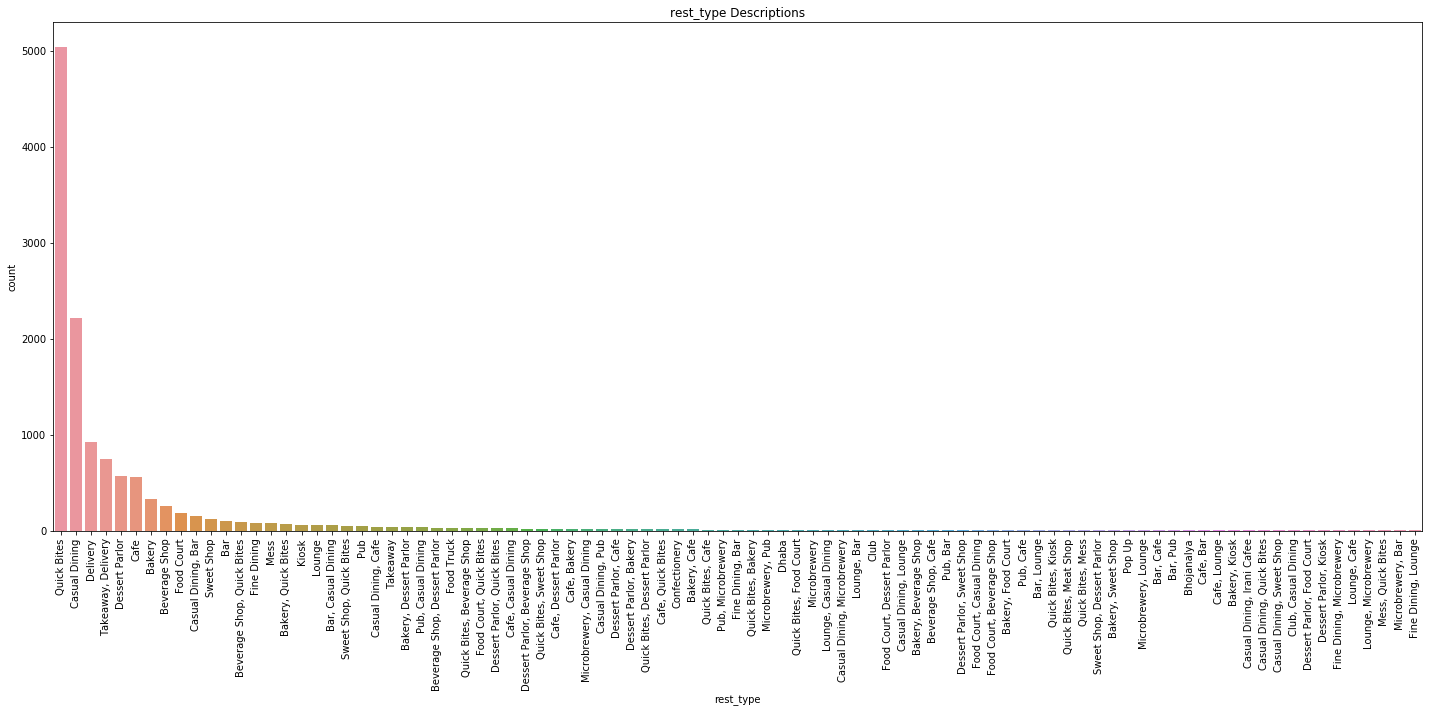

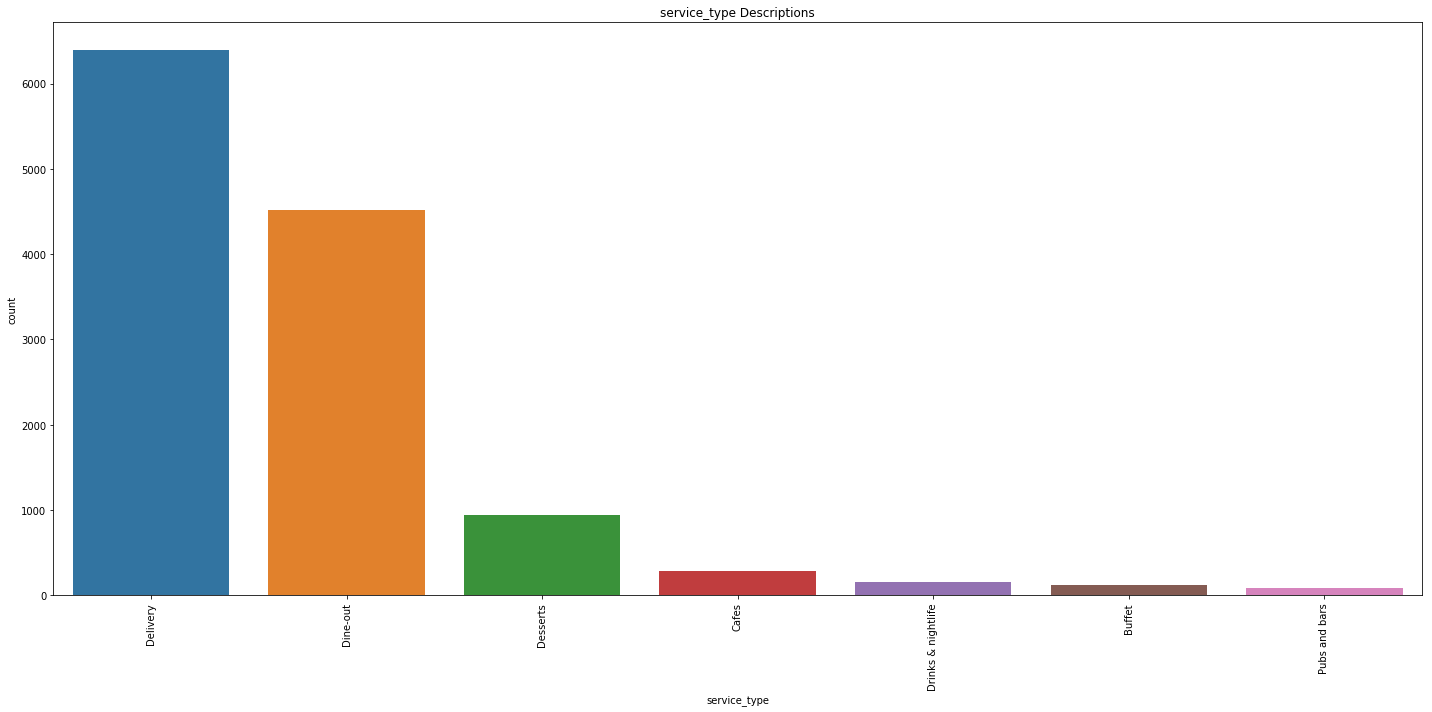

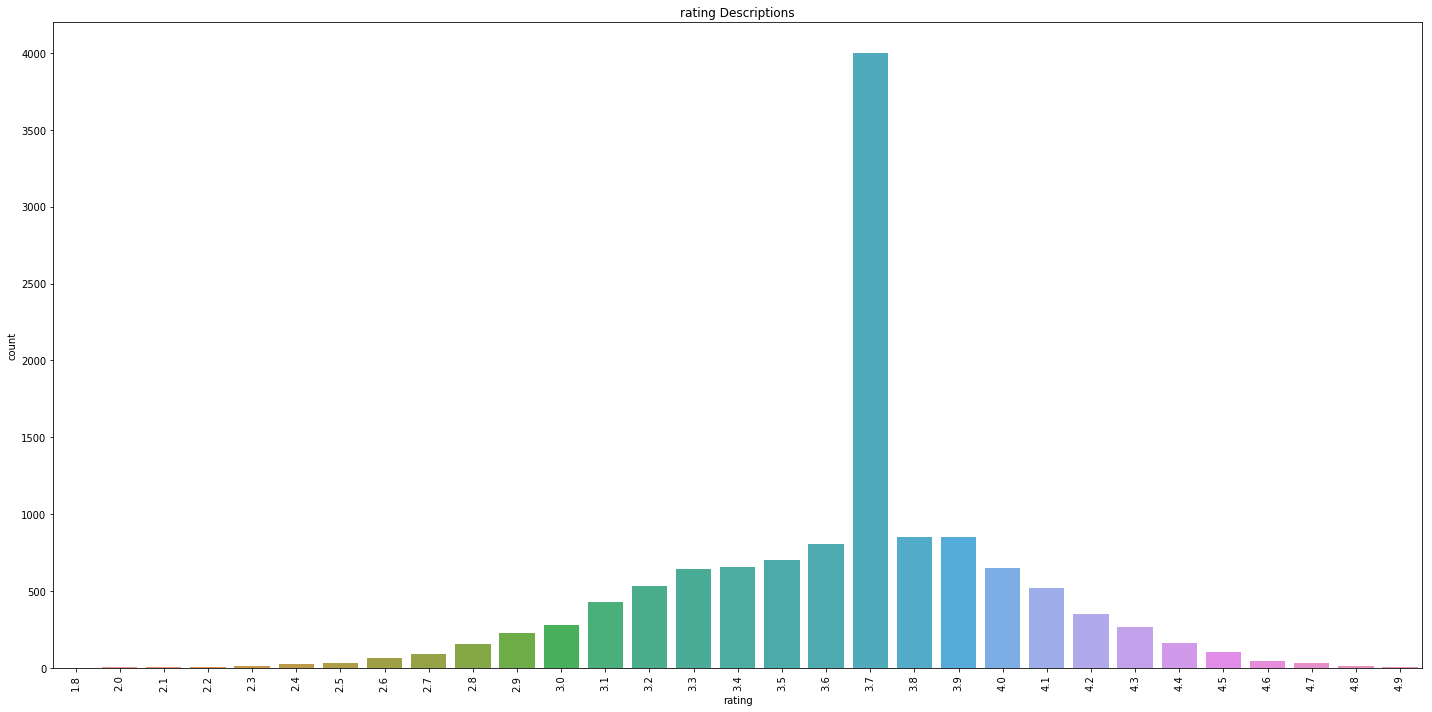

Text(0.5, 0, 'Number of outlets')

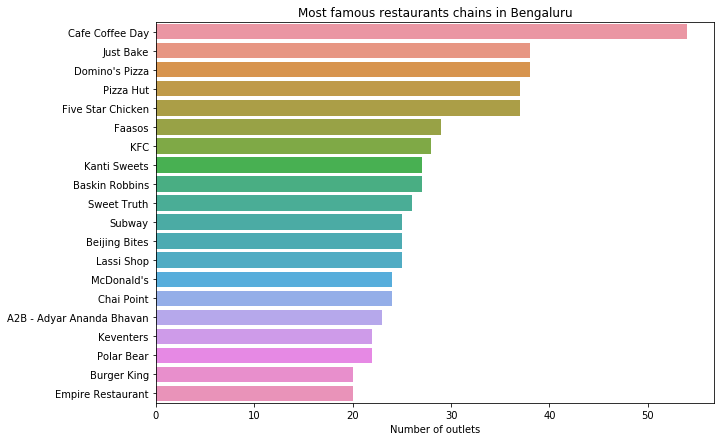

In [15]:
# bar graph to find trends in the dataset
def display_barChart(field):
    plt.figure(figsize=(20, 10))
    _temp = pd.DataFrame(data.groupby(field)[field].count())
    _temp.columns = ["count"]
    _temp = _temp.reset_index()
    _temp.columns = [field, "count"]
    _temp = _temp.sort_values(by="count", ascending=False)
    plt.title(field+" Descriptions")
    g = sns.barplot(data=_temp, x=field, y="count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


display_barChart("location")
display_barChart("rest_type")
display_barChart('service_type')
display_barChart('rating')

plt.figure(figsize=(10,7))
chains=data['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index)
plt.title("Most famous restaurants chains in Bengaluru")
plt.xlabel("Number of outlets")


# Finding the neighborhood highest average rating 

  **Lavelle Road** is the neighbourhood with highest average rating. 
  The type of popular resturants in this neighbourbood is **ITALIAN**.
  The popular cuisine type here is **Casual Dining**.

In [0]:
newdf = data.groupby('location')['rating'].mean()
newdf1 = newdf.sort_values(ascending=False)
newdf = data.loc[data['location'] == newdf1.index[0]]


In [0]:
allMap = {}
def categorial_calc(series,col):
  colmap = {}
  for row,ind in series.iteritems():
      values = ind.split(",")
      for value in values:
        value = value.strip()
        if value in colmap:
          colmap[value] = colmap[value] + 1
        else:
          colmap[value] = 1
  allMap[col] = colmap
def get_stats_df():
  for col in newdf.columns:
    #if data[col].dtypes == "int64":
    #  numerical_calc(col)
    if newdf[col].dtype == "object":
      categorial_calc(newdf[col],col)

In [0]:
get_stats_df()

# Plotting the Characteristics of the neighbourhood

Type of Cuisines in the particular location

In [19]:
cuisines_type = sorted(allMap['cuisines'].items() , reverse=True, key=lambda x: x[1])
#Iterate over the sorted sequence
for row in cuisines_type :
    print(row[0] , ":" , row[1] ) 

Italian : 14
North Indian : 12
Continental : 12
Desserts : 11
Salad : 7
Bakery : 6
Asian : 6
Cafe : 6
Chinese : 6
European : 4
Japanese : 4
Thai : 4
Seafood : 4
Fast Food : 3
Pizza : 3
Mediterranean : 3
Ice Cream : 3
South Indian : 2
French : 2
BBQ : 2
Spanish : 2
Steak : 2
Healthy Food : 2
Beverages : 2
Mughlai : 2
American : 2
Finger Food : 2
Momos : 2
Street Food : 1
Sandwich : 1
Burger : 1
North Eastern : 1
Modern Indian : 1
Kebab : 1
Mangalorean : 1
Rajasthani : 1
Mexican : 1
Tex-Mex : 1
Juices : 1
Parsi : 1
Indonesian : 1


<Figure size 1440x720 with 0 Axes>

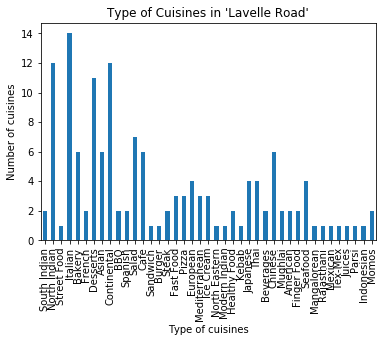

In [20]:
cuisine_labels = [] #create an empty list to store the labels
for key, value in allMap['cuisines'].items():
    cuisine_labels.append(key)
    
plt.figure(figsize=(20, 10))
ax= pd.DataFrame(allMap['cuisines'].items()).plot(kind='bar')
ax.set_title("Type of Cuisines in '{location}'".format(location=newdf1.index[0]))
ax.set_ylabel('Number of cuisines')
ax.set_xlabel('Type of cuisines')
ax.set_xticklabels(cuisine_labels)
ax.get_legend().remove()
plt.show()

Type of resturants in that location

In [21]:
rest_type = sorted(allMap['rest_type'].items() , reverse=True, key=lambda x: x[1])
#Iterate over the sorted sequence
for row in rest_type :
    print(row[0] , ":" , row[1] )

Casual Dining : 21
Bar : 10
Fine Dining : 7
Quick Bites : 6
Bakery : 6
Cafe : 6
Dessert Parlor : 5
Microbrewery : 4
Lounge : 4
Pub : 2
Beverage Shop : 2
Delivery : 1
Kiosk : 1
Confectionery : 1
Irani Cafee : 1


<Figure size 1440x720 with 0 Axes>

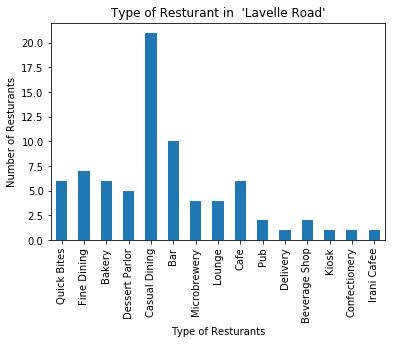

In [22]:
resturant_labels = [] #create an empty list to store the labels
for key, value in allMap['rest_type'].items():
    resturant_labels.append(key)    

plt.figure(figsize=(20, 10))
ax= pd.DataFrame(allMap['rest_type'].items()).plot(kind='bar')
ax.set_title("Type of Resturant in  '{location}'".format(location=newdf1.index[0]))
ax.set_ylabel('Number of Resturants')
ax.set_xlabel('Type of Resturants')
ax.set_xticklabels(resturant_labels)
ax.get_legend().remove()
plt.show()

# Explain what is the task you’re solving?

 We are solving a **Supervised learning** problem since we know our target objective which is to find the approximate cost of the meal for 2 people using the given attributes. Under supervised learning this is a **Regression** problem as we are predicting a numeric value which is the cost of a meal. 

# What models will you choose? Why?

We used **Regression** model for analyzing the dataset. We tried using 3 different regression models such as AdaBoost Regressor, MLP Regressor and XGBoost Regressor. The reason why we choose these regression models are explained below:

**AdaBoost Regressor** : Switching from linear regression to AdaBoost allows us to capture many of the non-linear relationships, which translates into better prediction on the problem of interest.

**MLP Regressor**: MLPRegressor trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters. It can also have a regularization term added to the loss function that shrinks model parameters to prevent overfitting.

**XGBoost Regressor**: The advantages of using this is because it supports Regularization,  Parallel Processing, High Flexibility and Handling Missing Values

# Which metrics will you use to evaluate your model?

We are using the following metrics to evaluate our model.
Variance, Explained_variance, neg_mean_squared_error, r2_score

**R2_score** Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

# How do you make sure not to overfit?

We are using a fitting graph to visualize that our model is not overfitting. And in XGBoost Regessor it has an inbuilt Tree Pruning algorithm that will start pruning the tree backwards and remove splits beyond which there is no positive gain. 

# Data Preprocessing

In [0]:
# using imputer on catagorical columns
col_category = []
col_number = []
for datas in data.columns:
    if data[datas].map(type).eq(str).any():
        col_category.append(datas)
    else:
        col_number.append(datas)

In [0]:
# create two DataFrames, one for each data type
data_numeric = pd.DataFrame(data[col_number])
data_categorical = pd.DataFrame(data[col_category])

In [0]:
# imputing the missing values with most-frequent values of the column
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
data_categorical = imp.fit_transform(data_categorical)
data_joined = pd.DataFrame(np.concatenate(
    [data_numeric, data_categorical], axis=1))

In [0]:
# assigning column names after concatenation of numeric and categorical dataframes
data_joined.columns = ['online_order', 'book_table', 'rating', 'votes',
                       'average_cost', 'name', 'location', 'rest_type', 'cuisines', 'service_type']


In [0]:
# scale 'rating', 'votes', 'average_cost' to fit between 0,1
scaler = MinMaxScaler()
data_joined[['rating', 'votes', 'average_cost']] = scaler.fit_transform(
    data_joined[['rating', 'votes', 'average_cost']])

In [0]:

# Preparing training dataset
df_train_data = data_joined.drop(columns=['average_cost', 'name'])
df_train_label = data_joined.average_cost

In [0]:
# label encoding for column cuisines
encode = LabelEncoder()
df_train_data['cuisines'] = encode.fit_transform(df_train_data['cuisines'])

In [0]:
# dummy-up the categorical data
list_dummy = ['rest_type',
              'service_type', 'location']


def to_dummy(df, list_dummy):
    for x in list_dummy:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [0]:
# passing data to the function
df_train_data = to_dummy(df_train_data, list_dummy)

In [0]:
# change datatype for the attribute to perform regression
df_train_data = df_train_data.astype('float')
df_train_label = df_train_label.astype('float')

In [0]:
# splitting preprocessed data into train and validation
X_train, X_test, y_train, y_test = train_test_split(
    df_train_data, df_train_label, test_size=0.25, random_state=0)

# Evaluation Approach and Metrics used

  The evaluation approach that is being used is Cross validation since it would create a K-fold cross validation. The advantage of using cross validation is because:
 - More efficient estimate than out-of-sample validation.
 - More efficient use of data as every observation is used for both training and testing.


> The metrics used are:
  - Variance
  - Explained_variance
  - neg_mean_squared_error
  - r2_score



In [0]:
# explained_variance_score  mean_absolute_error
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_validate

def model_eval(estimator_in, regressor_name):
    scoring = {'variance': 'explained_variance',
              'neg_mean_squared_error': 'neg_mean_squared_error',
              'r2_score':'r2'}
    
    scores = cross_validate(estimator=estimator_in, scoring=scoring,X=df_train_data, y=df_train_label, cv=5)
    print(regressor_name, "\n", scores)
    print("mean fit_time: ", scores['fit_time'].mean())
    print("mean score_time: ", scores['score_time'].mean())
    print("mean test_variance: ", scores['test_variance'].mean())
    print("mean test_neg_mean_squared_error: ", scores['test_neg_mean_squared_error'].mean())
    print("mean test_r2_score: ", scores['test_r2_score'].mean())
    return scores['test_variance'].mean()
    
# cross-val fitting graph for prediction errors

def cross_val_plot(regressor, regressor_name):
    predicted = cross_val_predict(
        regressor, df_train_data, df_train_label, cv=5)
    fig, ax = plt.subplots()
    ax.scatter(df_train_label, predicted, edgecolors=(0, 0, 0))
    ax.plot([df_train_label.min(), df_train_label.max()], [
            df_train_label.min(), df_train_label.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.title("Fitting Graph for '{var_name}' ".format(
        var_name=regressor_name))
    plt.show()


In [0]:
# Create CV training and test scores for various training set sizes


def plot_learning_curve(regressor, regressor_name):
    train_sizes, train_scores, test_scores = learning_curve(regressor,
                                                            df_train_data,
                                                            df_train_label,
                                                            cv=5,
                                                            scoring='explained_variance',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 5))
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    # Draw lines
    plt.plot(train_sizes, train_mean, '--',
             color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111",
             label="Cross-validation score")
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, color="#DDDDDD")
    # Create plot
    plt.title("Learning Curve for '{var_name}' ".format(
        var_name=regressor_name))
    plt.xlabel("Training Set Size"), plt.ylabel(
        "explained_variance"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()



# AdaBoost Regressor

AdaBoostRegressor: 
 {'fit_time': array([21.72560549, 21.18389177, 21.37385464, 21.42696142, 20.53195834]), 'score_time': array([0.97740412, 1.00280428, 0.96568227, 0.96147895, 0.9671607 ]), 'test_variance': array([0.63686051, 0.67080137, 0.69284952, 0.59686705, 0.68772587]), 'test_neg_mean_squared_error': array([-0.00206332, -0.00176696, -0.00228172, -0.00198215, -0.00206084]), 'test_r2_score': array([0.52859913, 0.50408338, 0.53579537, 0.44547121, 0.58251245])}
mean fit_time:  21.248454332351685
mean score_time:  0.974906063079834
mean test_variance:  0.6570208620245716
mean test_neg_mean_squared_error:  -0.0020309970382467956
mean test_r2_score:  0.5192923087886061


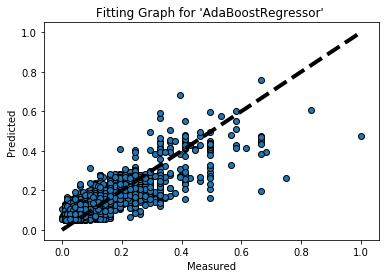

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


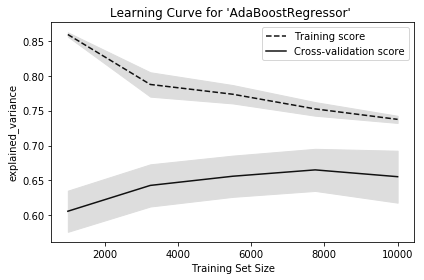

In [196]:
# Adaboost
ada = AdaBoostRegressor(n_estimators=300, learning_rate=0.1,
                        base_estimator=DecisionTreeRegressor(max_depth=6))
scoreada = model_eval(ada, "AdaBoostRegressor:")
cross_val_plot(ada, "AdaBoostRegressor")
plot_learning_curve(ada, "AdaBoostRegressor")

In [197]:
ada.fit(X_train, y_train)

predict_adaboost_test = ada.predict(X_test)
predict_adaboost_train = ada.predict(X_train)

variance_adaboost_test = explained_variance_score(
y_test, predict_adaboost_test, multioutput='uniform_average')
variance_adaboost_train = explained_variance_score(
y_train, predict_adaboost_train, multioutput='uniform_average')

print('Variance score for Adaboost_train: ',variance_adaboost_train)
print('Variance score for Adaboost_test: ',variance_adaboost_test)

Variance score for Adaboost_train:  0.7384009098956164


# MLPRegressor

MLP_Regressor: 
 {'fit_time': array([4.8292954 , 3.68959284, 4.22026157, 4.5377593 , 4.57025719]), 'score_time': array([0.04388928, 0.04209995, 0.04092789, 0.0403893 , 0.04103899]), 'test_variance': array([0.71002292, 0.67170466, 0.70237353, 0.67164952, 0.69796143]), 'test_neg_mean_squared_error': array([-0.00142271, -0.00123474, -0.00158662, -0.00119593, -0.00169599]), 'test_r2_score': array([0.67495808, 0.6534557 , 0.67721069, 0.66542556, 0.65642327])}
mean fit_time:  4.369433259963989
mean score_time:  0.04166908264160156
mean test_variance:  0.6907424119729335
mean test_neg_mean_squared_error:  -0.0014271974473198472
mean test_r2_score:  0.6654946607522642


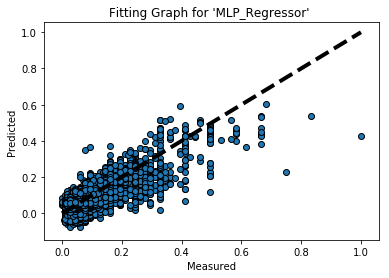

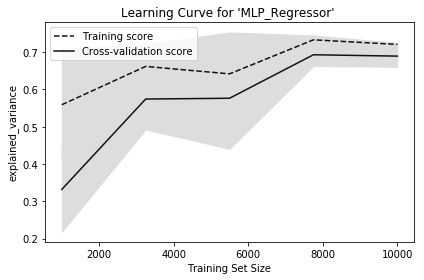

In [39]:
# MLPRegressor
MLP_Regressor = MLPRegressor(hidden_layer_sizes=(
    250), activation='relu', max_iter=200)
scoremlp = model_eval(MLP_Regressor, "MLP_Regressor:")
cross_val_plot(MLP_Regressor, "MLP_Regressor")
plot_learning_curve(MLP_Regressor, "MLP_Regressor")

In [40]:
MLP_Regressor.fit(X_train, y_train)

predict_MLP_Regressor_test = MLP_Regressor.predict(X_test)
predict_MLP_Regressor_train = MLP_Regressor.predict(X_train)

variance_MLP_Regressor_test = explained_variance_score(
y_test, predict_MLP_Regressor_test, multioutput='uniform_average')
variance_MLP_Regressor_train = explained_variance_score(
y_train, predict_MLP_Regressor_train, multioutput='uniform_average')

print('Variance score for MLP_Regressor_train: ',variance_MLP_Regressor_train)
print('Variance score for MLP_Regressor_test: ',variance_MLP_Regressor_test)

Variance score for MLP_Regressor_train:  0.6872205370578122
Variance score for MLP_Regressor_test:  0.6666226041089419


# XGBRegressor

Grid Search is performed on XGBoost for hyper-parameter tuning. Grid search trains the algorithm for all combinations by using learning rate and number of layers as hyperparameters and measures the performance using “Cross Validation” technique. This validation technique gives assurance that our trained model got most of the patterns from the dataset. We are using “K-Fold Cross Validation” to tune the model using multiple combination of training and validation sets [10].

Yes we can tune the hyperparamters using GridSearch. 

> So tunning the hyperparameters improves the performance because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model being trained.



In [0]:
xgboost_Regressor = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.01,0.02], #so called `eta` value
              'max_depth': [7,8,9],
              'min_child_weight': [4],
              'subsample': [0.5,0.7],
              'colsample_bytree': [0.7,0.8],
              'n_estimators': [200,400]}

xgb_grid = GridSearchCV(xgboost_Regressor,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(df_train_data,df_train_label)
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


xgboost_Regressor: 
 {'fit_time': array([4.02410841, 3.81116915, 3.86935019, 3.92761135, 3.82039404]), 'score_time': array([0.08996224, 0.09386158, 0.09112501, 0.08966064, 0.09012365]), 'test_variance': array([0.75463501, 0.76078313, 0.77413287, 0.7286302 , 0.77210652]), 'test_neg_mean_squared_error': array([-0.00107924, -0.00085362, -0.00111057, -0.00097022, -0.0011253 ]), 'test_r2_score': array([0.75342915, 0.76042254, 0.77406133, 0.72857044, 0.77203497])}
mean fit_time:  3.890526628494263
mean score_time:  0.090946626663208
mean test_variance:  0.7580575455506215
mean test_neg_mean_squared_error:  -0.0010277880060363767
mean test_r2_score:  0.7577036860261636


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


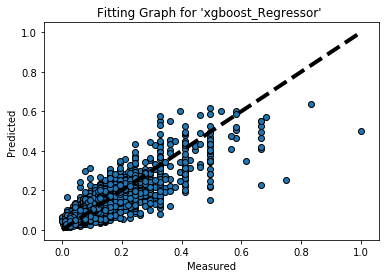

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


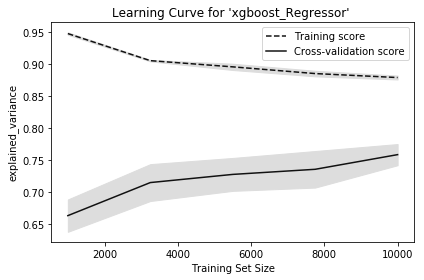

In [201]:
#xgboost
xgboost_Regressor = XGBRegressor(colsample_bytree = 0.7, 
                                 learning_rate= 0.03, 
                                 max_depth= 9, 
                                 min_child_weight= 4, 
                                 n_estimators= 400, 
                                 nthread= 4, 
                                 silent= 1, 
                                 subsample= 0.7,
                                predictor = 'gpu_predictor',
                                tree_method = 'gpu_hist',
                                reg_alpha=0.005,
                                seed=28,
                                objective='reg:squarederror')
scorexgboost = model_eval(xgboost_Regressor, "xgboost_Regressor:")
cross_val_plot(xgboost_Regressor, "xgboost_Regressor")
plot_learning_curve(xgboost_Regressor, "xgboost_Regressor")

In [202]:
# Predicting the Test set results for xgboost
xgboost_Regressor.fit(X_train, y_train)

xgboost_pred_test = xgboost_Regressor.predict(X_test)
xgboost_pred_train = xgboost_Regressor.predict(X_train)

variance_xgboost_test = explained_variance_score(
    y_test, xgboost_pred_test, multioutput='uniform_average')

variance_xgboost_train = explained_variance_score(
    y_train, xgboost_pred_train, multioutput='uniform_average')

print('Variance score for xgboost_train: ',variance_xgboost_train)
print('Variance score for xgboost_test: ',variance_xgboost_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Variance score for xgboost_train:  0.8802718830782172
Variance score for xgboost_test:  0.7681484903879209


# Graph comparing Train and Test scores

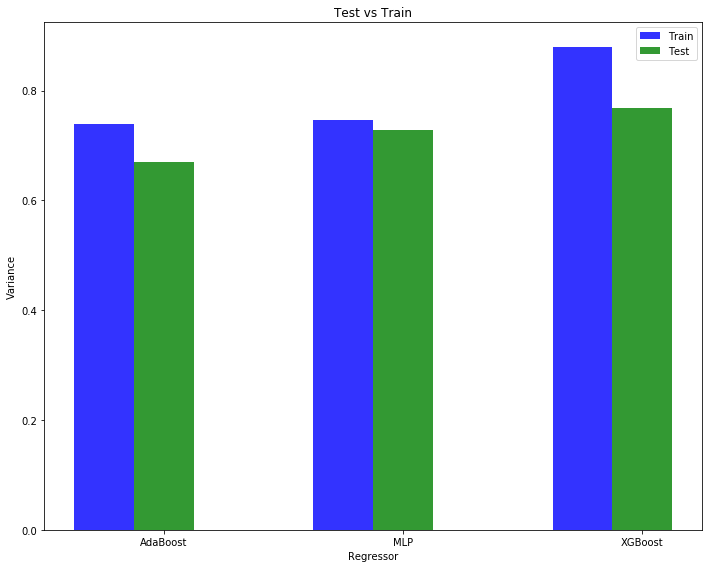

In [207]:
#Graph comparing Train and Test scores
import numpy as np
import matplotlib.pyplot as plt
n_groups = 3

train_variance =(variance_adaboost_train,variance_MLP_Regressor_train,variance_xgboost_train)
test_variance= (variance_adaboost_test,variance_MLP_Regressor_test,variance_xgboost_test)

fig, ax = plt.subplots(figsize=(10, 8))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = ax.bar(index, train_variance, bar_width,alpha=opacity,color='b',label='Train')

rects2 = ax.bar(index + bar_width, test_variance, bar_width,alpha=opacity,color='g',label='Test')

plt.xlabel('Regressor')
plt.ylabel('Variance')
plt.title('Test vs Train')
plt.xticks(index + bar_width, ('AdaBoost', 'MLP', 'XGBoost'))
plt.legend()

plt.tight_layout()
plt.show()  



# Graph to predict the best Model

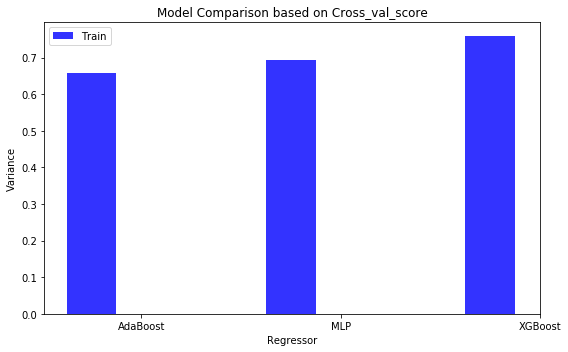

In [208]:
#Graph to predict the best Model
import numpy as np
import matplotlib.pyplot as plt
n_groups = 3

regressors =(scoreada,scoremlp,scorexgboost)

fig, ax = plt.subplots(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = ax.bar(index, regressors, bar_width,alpha=opacity,color='b',label='Train')

plt.xlabel('Regressor')
plt.ylabel('Variance')
plt.title('Model Comparison based on Cross_val_score')
plt.xticks(index + bar_width, ('AdaBoost', 'MLP', 'XGBoost'))
plt.legend()

plt.tight_layout()
plt.show()  

In [0]:
pip install skrebate
pip install ReliefF
pip install numpy 


# Relief feature

In [0]:
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF


from skrebate import TuRF  
headers = list(df_train_data)

reg_relief = make_pipeline(TuRF(core_algorithm="ReliefF", n_features_to_select=2, pct=0.5),
                    XGBRegressor(colsample_bytree = 0.7, 
                                 learning_rate= 0.03, 
                                 max_depth= 9, 
                                 min_child_weight= 4, 
                                 n_estimators= 400, 
                                 nthread= 4, 
                                 silent= 1, 
                                 subsample= 0.7,
                                predictor = 'gpu_predictor',
                                tree_method = 'gpu_hist',
                                reg_alpha=0.005,
                                seed=28,
                                objective='reg:squarederror',
                                gpu_id = 0, max_bin = 100))

# print(cross_val_score(reg_relief,df_train_data.values, df_train_label.values))
print(np.mean(cross_val_score(reg_relief, df_train_data.values, df_train_label.values, fit_params={'turf__headers': headers})))


In [0]:
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
reg_relief = make_pipeline(ReliefF(n_features_to_select=4, n_neighbors=100),
                    XGBRegressor(colsample_bytree = 0.7, 
                                 learning_rate= 0.03, 
                                 max_depth= 9, 
                                 min_child_weight= 4, 
                                 n_estimators= 400, 
                                 nthread= 4, 
                                 silent= 1, 
                                 subsample= 0.7,
                                predictor = 'gpu_predictor',
                                tree_method = 'gpu_hist',
                                reg_alpha=0.005,
                                seed=28,
                                objective='reg:squarederror',
                                gpu_id = 0, max_bin = 100))

print(cross_val_score(reg_relief,df_train_data.values, df_train_label.values))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


# REFERENCES

[1] "Xgboost in python- Machine Learning Tutorial with Python -Part 13", YouTube, 2019. [Online]. Available: https://www.youtube.com/watch?v=DuwrMrPpPMw. [Accessed: 03- Jul- 2019].

[2]"Finding the best restaurants in Bangalore | Kaggle", Kaggle.com, 2019. [Online]. Available: https://www.kaggle.com/parthsharma5795/finding-the-best-restaurants-in-bangalore. [Accessed: 03- Jul- 2019].

[3]"Bangalore Restaurants EDA Analysis | Kaggle", Kaggle.com, 2019. [Online]. Available: https://www.kaggle.com/ranganadhkodali/bangalore-restaurants-eda-analysis. [Accessed: 03- Jul- 2019].

[4]"Sagarsharma4244/Cross-Validation", GitHub, 2019. [Online]. Available: https://github.com/Sagarsharma4244/Cross-Validation/blob/master/Visualization_cross_validation.py. [Accessed: 03- Jul- 2019].

[5]"Plotting Learning Curves — scikit-learn 0.21.2 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. [Accessed: 03- Jul- 2019].

[6]M. Learning and C. Python, "Complete Guide to Parameter Tuning in XGBoost (with codes in Python)", Analytics Vidhya, 2019. [Online]. Available: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/. [Accessed: 03- Jul- 2019].

[7]"Cross Validation in Machine Learning - GeeksforGeeks", GeeksforGeeks, 2019. [Online]. Available: https://www.geeksforgeeks.org/cross-validation-machine-learning/. [Accessed: 03- Jul- 2019].

[8]"3.3. Model evaluation: quantifying the quality of predictions — scikit-learn 0.21.2 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/model_evaluation.html. [Accessed: 03- Jul- 2019].

[9]"sklearn.neural_network.MLPRegressor — scikit-learn 0.21.2 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor. [Accessed: 03- Jul- 2019].

[10]"Understanding Hyperparameters and its Optimisation techniques", Towards Data Science, 2019. [Online]. Available: https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568. [Accessed: 03- Jul- 2019].